In [1]:
import pandas as pd
import numpy as np

def get_time_series_for_window(start_date, end_date, station, dataframe):
    return dataframe.loc[start_date:end_date, [station]]


def check_nan_values(dataframe):
    return dataframe.isnull().values.any()


def get_valid_sequences(df):
    valid_sequences = []
    starting_idx = 0

    for i, (_, row) in enumerate(df.iterrows()):
        flow = row[0]

        if np.isnan(flow):

            if starting_idx < i-1:
                valid_sequences.append((starting_idx, i))
                starting_idx = i+1
            else:
                starting_idx = i+1
                continue
    
    if not check_nan_values(df.iloc[starting_idx:, :]):
        valid_sequences.append((starting_idx, len(df)))
    return valid_sequences


def valid_seqs_minimum_len(valid_seqs, seq_len):
    
    valid_seqs_min_len = []
    pops = []
    for i, (start, end) in enumerate(valid_seqs):
        if end - start >= seq_len:
            valid_seqs_min_len.append((start, end))

    return valid_seqs_min_len



def split_sequences(possible_seqs, split_len):
    
    usable_seqs = []
    for seq in possible_seqs:
        usable_seqs += get_seq_splits(seq, split_len)
        
    return usable_seqs
        
        
        
def get_seq_splits(seq, split_len):
    
    start = seq[0]
    end = seq[1]
    
    chunks = (end - start) // (split_len+1)     # +1 because there must be an unobserved item after each chunk
                                                # which will be the y (after window value)

    splits = []
    prev_end_chunk = start
    for i in range(chunks):

        start_chunk = prev_end_chunk
        end_chunk = start_chunk + split_len
        splits.append((start_chunk, end_chunk))
        prev_end_chunk = end_chunk+1
        
    return splits


def get_seq_obs_values(seq, df):
    return np.array(df.iloc[seq[0]:seq[1], :]), np.array(df.iloc[seq[1], :])


def split_seqs_train_test(train_frac, usable_seqs):
    
    total_seqs = len(usable_seqs)
    train_amount = round(total_seqs * train_frac)
    
    random.shuffle(usable_seqs)
    train_seqs = usable_seqs[0:train_amount]
    test_seqs = usable_seqs[train_amount:]
    
    return train_seqs, test_seqs


def mount_trainable_testable_arrays(seqs, df):
    
    x_data = []
    y_data = []
    for seq in seqs:
        x, y = get_seq_obs_values(seq, df)
        x_data.append(x)
        y_data.append(y)
    
    return np.array(x_data), np.array(y_data)



def transform_cleb_df_into_wal_df(cleb_df):
    
    index_names = {}
    for i, (_, row) in enumerate(cleb_df.iterrows()):
        
        year = str(int(row[2]))
        month = str(int(row[1]))
        day = str(int(row[0]))
        hour = str(int(row[3]))
        index_name = year+'-'+month+'-'+day+'-'+hour
        
        index_names[i] = index_name
        
    
    cleb_df.rename(index=index_names)
    cleb_df = cleb_df.drop('day', 1)
    cleb_df = cleb_df.drop('month', 1)
    cleb_df = cleb_df.drop('year', 1)
    cleb_df = cleb_df.drop('hour', 1)
    return cleb_df.replace(-1, np.nan)





flow_path = "/home/colombelli/Documents/hydro-ml/data/Vazao.txt"
rain_path = "/home/colombelli/Documents/hydro-ml/data/Chuva.txt"
et_path = "/home/colombelli/Documents/hydro-ml/data/ET.txt"

flow_df = pd.read_csv(flow_path, sep="\t", header=None)
flow_df.columns = ["day", "month", "year", "hour", "flow"]

rain_df = pd.read_csv(rain_path, sep="\t", header=None)
rain_df.columns = ["day", "month", "year", "hour", "rain"]

et_df = pd.read_csv(et_path, sep="\t", header=None)
et_df.columns = ["day", "month", "year", "hour", "et"]


flow_df = transform_cleb_df_into_wal_df(flow_df)
rain_df = transform_cleb_df_into_wal_df(rain_df)
et_df = transform_cleb_df_into_wal_df(et_df)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [192]:
dataset = pd.concat([flow_df, rain_df, et_df, flow_df], axis=1)
dataset.columns = ['flow', 'rain', 'et', 'y']

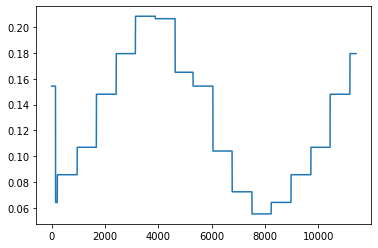

In [194]:
#plt.plot(np.array(dataset.iloc[6078:18500, 0:1]).flatten())
plt.plot(np.array(dataset.iloc[6078:17486, 2:3]).flatten())

In [169]:
n_steps_in = 4 #a week
n_steps_out = 1  #the next day

In [170]:
to_split = np.array(dataset.iloc[6078:17486, ])
X, y = split_sequences(to_split, n_steps_in, n_steps_out)

In [175]:
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, 
               activation='sigmoid',
               input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [176]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
357/357 [==============================] - 3s 9ms/step - loss: 291483.4688
Epoch 2/200
357/357 [==============================] - 3s 9ms/step - loss: 275885.3125
Epoch 3/200
357/357 [==============================] - 3s 9ms/step - loss: 262406.0000
Epoch 4/200
357/357 [==============================] - 3s 9ms/step - loss: 249959.4688
Epoch 5/200
357/357 [==============================] - 3s 10ms/step - loss: 238371.2656
Epoch 6/200
357/357 [==============================] - 4s 10ms/step - loss: 227729.2344
Epoch 7/200
357/357 [==============================] - 4s 10ms/step - loss: 218001.6875
Epoch 8/200
357/357 [==============================] - 3s 10ms/step - loss: 208955.8906
Epoch 9/200
357/357 [==============================] - 4s 10ms/step - loss: 200495.1562
Epoch 10/200
357/357 [==============================] - 4s 10ms/step - loss: 192582.8281
Epoch 11/200
357/357 [==============================] - 3s 10ms/step - loss: 185105.7812
Epoch 12/200
357/357 [============

KeyboardInterrupt: 

In [115]:
x_test = np.array(dataset.iloc[17487:18718, 0:3])
y_test = np.array(dataset.iloc[17487:18718, 3:4])

x_test = x_test[100:100+n_steps_in].reshape((1, n_steps_in, n_features))
yhat = model.predict(x_test, verbose=0).flatten()

y_test = y_test[100+n_steps_in:100+n_steps_in+n_steps_out].flatten()

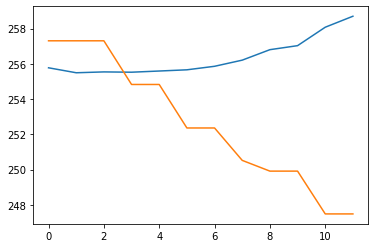

In [116]:
plt.plot(yhat)
plt.plot(y_test)

In [117]:
def get_nash(observed, modeled):
    
    mean_obs = np.mean(observed)
    
    variance = 0 
    squared_err = 0
    for t, obs_flow in enumerate(observed):
        squared_err += (modeled[t] - obs_flow) ** 2
        variance += (obs_flow - mean_obs) ** 2
        
    nash = 1 - (squared_err  / variance)
    return nash

In [118]:
get_nash(yhat, y_test)

-30.163116276834575

In [119]:
yhat

array([255.77686, 255.495  , 255.54349, 255.52644, 255.594  , 255.66267,
       255.86249, 256.21143, 256.80582, 257.03403, 258.08084, 258.7042 ],
      dtype=float32)

In [122]:
test = np.array(dataset.iloc[17800:18000, ])
#test = np.array(dataset.iloc[6078:17486, ])
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)

In [123]:
nash_acc = 0
for i, _ in enumerate(X_test):
    print(i)
    X = X_test[i].reshape((1, n_steps_in, n_features))
    predicted = model.predict(X, verbose=0).flatten()
    observed = y_test[i]
    nash_acc += get_nash(observed, predicted)
    
print("Average nash: ", nash_acc/len(X_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
Average nash:  -25.80184486430813


In [125]:
pred = model.predict(X_test[100].reshape((1, n_steps_in, n_features))).flatten()

In [126]:
y_test[100]

array([130.51, 130.1 , 130.1 , 130.1 , 129.69, 128.47, 128.47, 128.47,
       128.47, 127.26, 126.85, 126.85])

In [127]:
pred

array([129.04922, 129.09851, 129.37598, 129.73015, 130.24553, 130.70337,
       131.42223, 131.87424, 132.52272, 133.14233, 134.28036, 135.29509],
      dtype=float32)

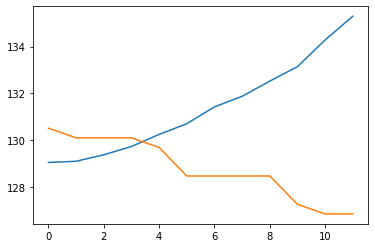

In [129]:
plt.plot(pred)
plt.plot(y_test[100])

In [134]:
get_nash(y_test[100][0:2], pred[0:2])

-36.32117503986073

In [135]:
print(y_test[100][0:2], pred[0:2])

[130.51 130.1 ] [129.04922 129.09851]
